# Table of Contents
- [Problem Definition](#intro)
- [Modules/Libraries](#modules)
- [Exploratory Data Analysis](#eda)
- [Variable Transformation](#transformation)
- [Modeling & Prediction](#modeling)
- [Conclusion](#conclusion)

## 👨🏻‍💻 Problem Definition <a id='intro'></a>
Analyzing and predicting sleep time is crucial for understanding its impact on health, productivity, and well-being. It helps identify factors affecting sleep and provides actionable insights to improve sleep patterns and overall quality of life.

In this exercise, we will take a look at the [Sleep Time Prediction Dataset from Kaggle](https://www.kaggle.com/datasets/govindaramsriram/sleep-time-prediction/data) and evaluate how some human daily activity indicators (caffeine intake, work hours, phone usage, etc.) may impact sleep time.

## ⚒️ Import data & modules <a id='modules'></a>
We will mainly use some standard tools for data analysis, plus some visualization libraries to explore variables and relationships between them.

In [93]:
# Tools
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import shapiro
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [94]:
# Use Kaggle API to import the dataset
path = kagglehub.dataset_download('govindaramsriram/sleep-time-prediction')
df = pd.read_csv(path + '/sleeptime_prediction_dataset.csv')

## 🔮 Exploratory Data Analysis (EDA) <a id='eda'></a>
Let's take a first look at the data and try to infer some relationship between variables and decide if we need some additional cleanup.

In [95]:
df.describe()

,WorkoutTime,ReadingTime,PhoneTime,WorkHours,CaffeineIntake,RelaxationTime,SleepTime
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1.495915,0.992785,2.985195,6.926945,147.493780,1.010955,4.884375
std,0.876639,0.577303,1.151776,1.723843,84.651139,0.582619,2.028892
min,0.010000,0.000000,1.000000,4.000000,0.020000,0.000000,0.150000
25%,0.710000,0.500000,1.990000,5.440000,75.980000,0.510000,3.840000
50%,1.520000,0.990000,2.965000,6.910000,146.010000,1.010000,4.600000
75%,2.250000,1.500000,3.960000,8.422500,218.902500,1.530000,5.470000
max,3.000000,2.000000,5.000000,10.000000,299.850000,2.000000,19.810000


> 💡 We are dealing with a dataset of 2k observations, 6 independent variables (`WorkoutTime`, `ReadingTime`, `PhoneTime`, `WorkHours`, `CaffeineIntake`, `RelaxationTime`) and one dependent variable `SleepTime`.

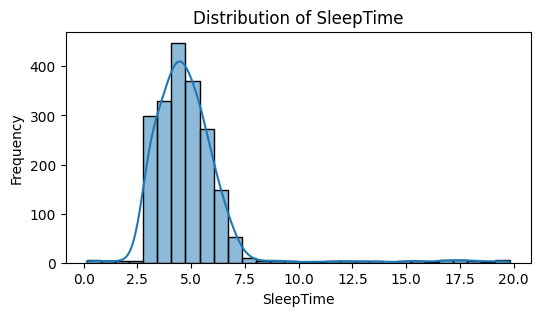

Shapiro-Wilk Test: Statistic=0.6535, p-value=0.0000
SleepTime does not appear to be normally distributed (reject H0).


In [96]:
# Let's check the distribution of the dependent variable
plt.figure(figsize=(6, 3))
sns.histplot(df['SleepTime'], kde=True, bins=30)
plt.title('Distribution of SleepTime')
plt.xlabel('SleepTime')
plt.ylabel('Frequency')
plt.show()

# Shapiro-Wilk test for normality
stat, p_value = shapiro(df['SleepTime'])
print(f'Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}')

if p_value > 0.05:
    print('SleepTime appears to be normally distributed (fail to reject H0).')
else:
    print('SleepTime does not appear to be normally distributed (reject H0).')

> 💡 The `SleepTime` variable is not normally distributed. We may need to perform some additional variable transformations to increase prediction accuracy.

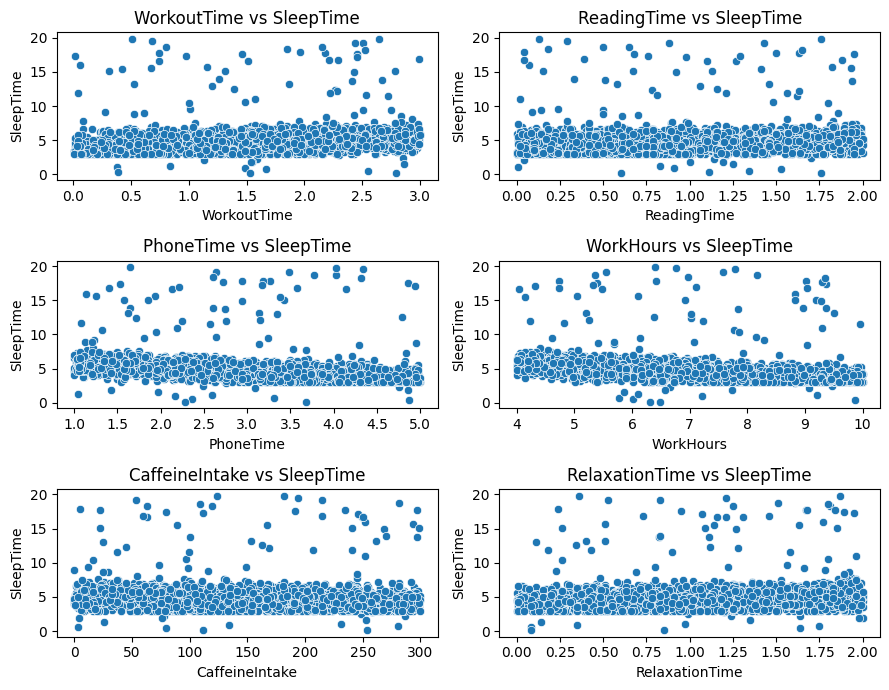

In [97]:
# Let's explore the nature of relationships between the predictors and dependent variable
# Scatterplots of variables vs SleepTime in smaller subplots
variables = ['WorkoutTime', 'ReadingTime', 'PhoneTime', 'WorkHours', 'CaffeineIntake', 'RelaxationTime']
num_vars = len(variables)
cols = 2
rows = (num_vars // cols) + (num_vars % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(9,7))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.scatterplot(data=df, x=var, y='SleepTime', ax=axes[i])
    axes[i].set_title(f'{var} vs SleepTime')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('SleepTime')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

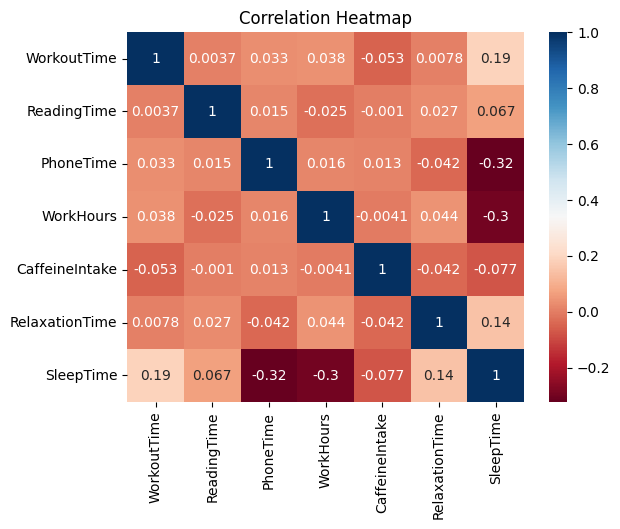

In [98]:
# Let's initially check the correlation matrix
sns.heatmap(df.corr(), cmap='RdBu',annot=True)
plt.title('Correlation Heatmap')
plt.show()

> To potentially improve the accuracy of the model, we can perform some qualitative/quantitative variable transformation:
> * categorization
> * feature engineering (combination, ratios, interactions)
> * encoding
> * feature reduction

## ✨ Variable Transformation <a id='transformation'></a>
As we have seen earlier, the relationships between dependent and independent variables is quite flat. To improve that, let's apply some common variable transformation techniques.

In [99]:
# First, let's create a new variable
# Each individual variable may not be very informative 
# Let's sum them all up to calculate Total Activity Time 

df['TotalActivityTime'] = df['WorkoutTime'] + df['ReadingTime'] + df['PhoneTime'] + df['WorkHours']

In [100]:
# There's one variable that strikes a sharp contrast with others
# Relaxation Time should logically be the opposite of Activity
# Let's introduce another variable: Activity vs Relaxation Ratio

df['ActivityRelaxRatio'] = df['TotalActivityTime'] / df['RelaxationTime']

In [101]:
# Physical activity is known to have a huge impact on sleep
# Let's calculate how high the % of physical activity is relative to total activity time

df['WorkoutTimeRatio'] = df['WorkoutTime'] / df['TotalActivityTime']

In [102]:
# Another good technique is to create new variable combinations
# Sometimes combinations are more meaningful predictors than individual variables

# This combination reflext the balance (imbalance) between work and relaxation
df['WorkRelaxationBalance'] = df['WorkHours'] * df['RelaxationTime']

# This combination represents some behavioral habits that may negatively impact sleep
df['LifestyleDisruptors'] = df['PhoneTime'] * df['CaffeineIntake']

In [103]:
# Auto-bucketing of CaffeineIntake using KBinsDiscretizer
kbd = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df['CaffeineIntake_binned'] = kbd.fit_transform(df[['CaffeineIntake']]).astype(int)
print('\nCaffeineIntake has been auto-bucketed into categories:')
print(df['CaffeineIntake_binned'].value_counts())

# Map bin labels for better interpretation
bin_edges = kbd.bin_edges_[0]
labels = [f'{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]
df['CaffeineIntake_binned_label'] = df['CaffeineIntake_binned'].map(dict(enumerate(labels)))
print('\nCaffeineIntake Binned Labels:')
print(df[['CaffeineIntake_binned', 'CaffeineIntake_binned_label']].drop_duplicates())

# No need for labels in the final dataset
df.drop('CaffeineIntake_binned_label', axis=1, inplace=True)



CaffeineIntake has been auto-bucketed into categories:
CaffeineIntake_binned
2    667
0    667
1    666
Name: count, dtype: int64

CaffeineIntake Binned Labels:
   CaffeineIntake_binned CaffeineIntake_binned_label
0                      2             194.68 - 299.85
2                      0                0.02 - 99.70
4                      1              99.70 - 194.68


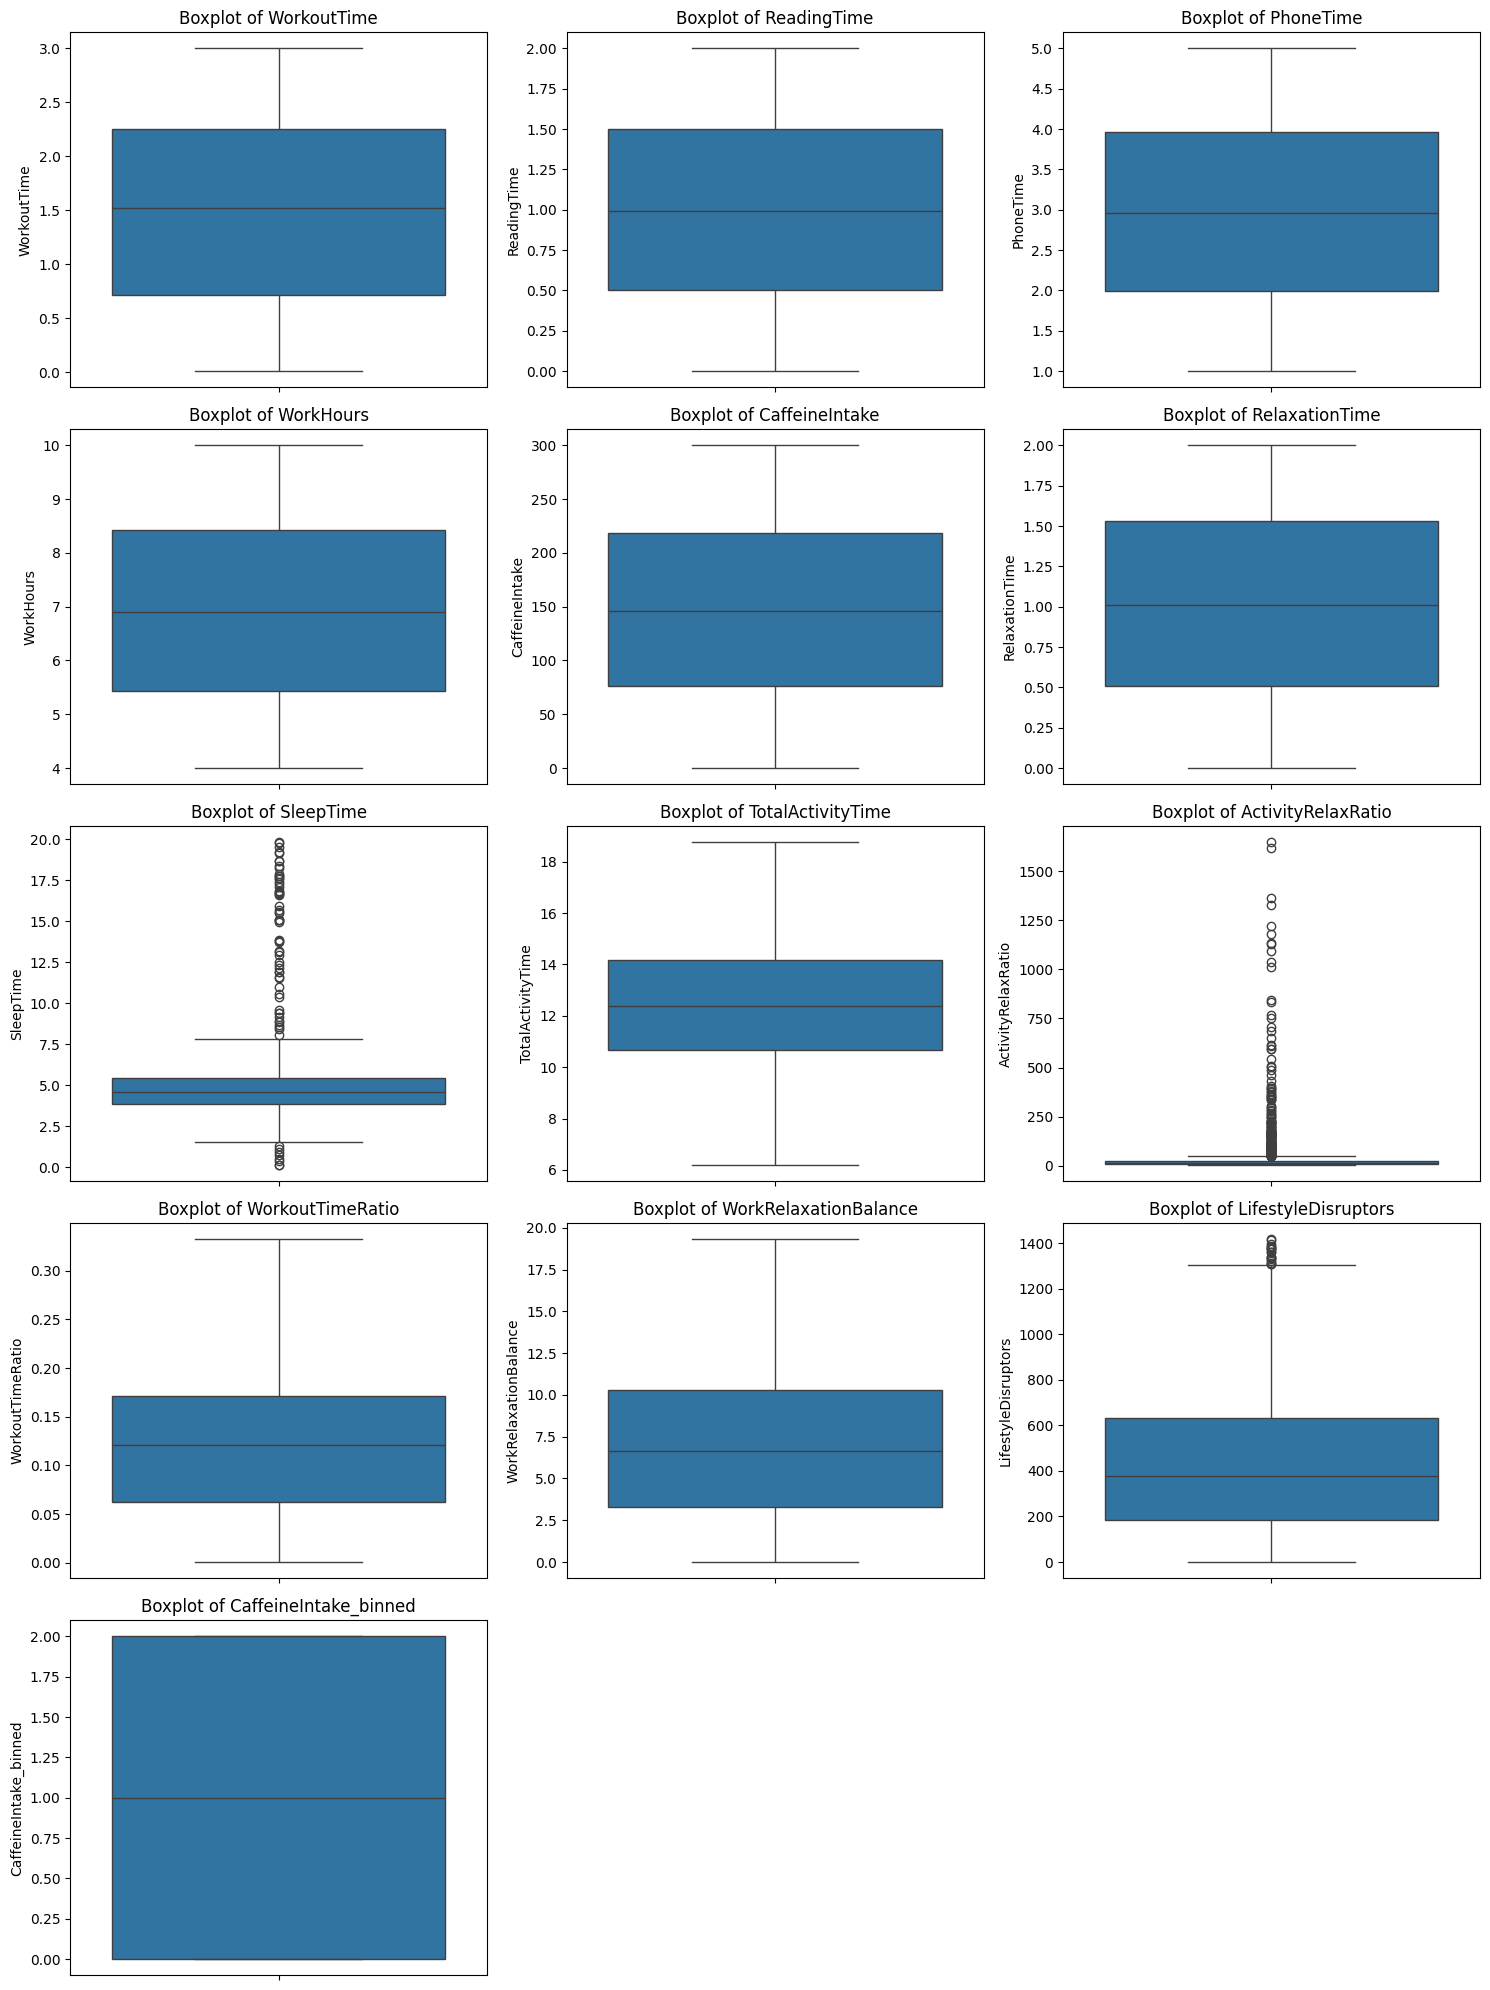

In [104]:
# Before diving into modelling
# Let's take a final look at the individual variables and variability among them

# Determine the grid size
n_cols = 3  # Number of columns in the matrix
n_rows = math.ceil(len(df.columns) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot each variable as a boxplot
for i, column in enumerate(df.columns):
    sns.boxplot(data=df, y=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(column)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

> 💡 There are quite a lot of outliers in the following variables: `SleepTime`, `ActivityRelaxRatio`, and `LifestyleDisruptors`. Let's clean them up.

In [105]:
# One common way to get rid of outliers is to use IQR Clipping

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower = lower_bound, upper = upper_bound)

    return df

In [106]:
# Looking at the boxplots above, we should definitely remove outliers in SleepTime

for var in ['SleepTime', 'ActivityRelaxRatio', 'LifestyleDisruptors']:
    df = remove_outliers(df, var)

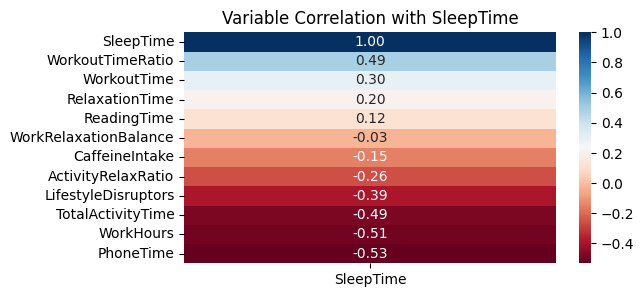

In [85]:
# Let's look at the final set of variables
correlation_matrix = df.corr(numeric_only=True)['SleepTime'].sort_values(ascending=False)
plt.figure(figsize=(6, 3))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='RdBu', fmt='.2f')
plt.title('Variable Correlation with SleepTime')
plt.show()

> 💡 Looks like not all the transformations were fruitful. For the prediction exercise, let's consider only the variables with a relatively high correlation (taking **0.3** as a threshold). 

In [107]:
# Define the threshold (Arbitrarily)
threshold = 0.3

# Select high-correlation features
correlation_matrix = pd.DataFrame(correlation_matrix.abs())
high_corr_variables = correlation_matrix[correlation_matrix['SleepTime'] >= threshold].index.to_list()
high_corr_variables.remove('SleepTime')

print('High Correlation Variables to be used in the model: \n', high_corr_variables)

High Correlation Variables to be used in the model: 
 ['WorkoutTimeRatio', 'LifestyleDisruptors', 'TotalActivityTime', 'WorkHours', 'PhoneTime']


## 🚀 Modeling & Prediction <a id='modeling'></a>
Let's do the standard modeling exercise. We will use several models and pick the best suitable one with the highest accuracy.

In [108]:
# Prepare for modeling
features = high_corr_variables
target = 'SleepTime'

# Train-test split
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [109]:
# Define models
models = {
    'Random Forest': RandomForestRegressor(random_state=11),
    'Gradient Boosting': GradientBoostingRegressor(random_state=11),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=11)
}

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)

    # Predict on train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate performance metrics for train and test sets
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)

    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    results.append({
        'Model': name,
        'Train R^2': train_r2,
        'Train MAE': train_mae,
        'Train MSE': train_mse,
        'Test R^2': test_r2,
        'Test MAE': test_mae,
        'Test MSE': test_mse
    })

# Create a comparison matrix
results_df = pd.DataFrame(results)
print('\nModel Comparison:')
print(results_df)


Model Comparison:
               Model  Train R^2  Train MAE  Train MSE  Test R^2  Test MAE  \
0      Random Forest   0.940949   0.162093   0.086588  0.746938  0.351810   
1  Gradient Boosting   0.773602   0.332824   0.331975  0.744908  0.360124   
2  Linear Regression   0.637594   0.362307   0.531408  0.788440  0.293117   
3      Decision Tree   1.000000   0.000000   0.000000  0.468996  0.491313   

   Test MSE  
0  0.346911  
1  0.349695  
2  0.290017  
3  0.727929  


## 📋 Conclusion <a id='conclusion'></a>
The**Random Forest** and **Gradient Boosting** models performed well, with Random Forest slightly outperforming due to its ability to handle non-linear relationships and interactions effectively. Linear Regression achieved the highest test R² score, indicating the relationships in the data might be predominantly linear (contrary to our initial expectation). The Decision Tree overfitted, highlighting the limitations of the model. 

To improve accuracy, **hyperparameter tuning** for Random Forest and Gradient Boosting is recommended, and **additional feature engineering** could help capture more complex relationships. Also, using **ensemble methods** like Random Forest or Gradient Boosting for the Decision Tree could improve its performance.